In [2]:
from datasets import load_dataset

dataset = load_dataset("eriktks/conll2003", trust_remote_code=True)
print(dataset['train'][0])
train_sentences = [example['tokens'] for example in dataset['train']]
train_labels = [example['ner_tags'] for example in dataset['train']]
label_list = dataset['train'].features['ner_tags'].feature.names  # List of NER tag names

{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}


In [5]:
from collections import defaultdict
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

MAX_LEN = 128 
word2idx = defaultdict(lambda: 1)  
word2idx["PAD"] = 0 
for sentence in train_sentences:
    for word in sentence:
        if word not in word2idx:
            word2idx[word] = len(word2idx)

X = [[word2idx[word] for word in sentence] for sentence in train_sentences]
X = pad_sequences(X, maxlen=MAX_LEN, padding='post')

PAD_LABEL = len(label_list) 


Y = pad_sequences(train_labels, maxlen=MAX_LEN, padding='post', value=PAD_LABEL)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1)

print(f"Training size: {len(X_train)}, Validation size: {len(X_val)}")

Training size: 12636, Validation size: 1405


In [7]:
!pip install tensorflow-addons


     -------------------------------------- 719.8/719.8 kB 7.5 MB/s eta 0:00:00


In [11]:
!pip install keras-crf


In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow_addons.text.crf import crf_log_likelihood, crf_decode


def build_bilstm_crf_model(max_len, n_words, n_tags):
    input = Input(shape=(max_len,))
    model = Embedding(input_dim=n_words, output_dim=128, input_length=max_len)(input)
    model = Bidirectional(LSTM(units=64, return_sequences=True))(model)
    logits = Dense(n_tags)(model)
    transition_params = tf.Variable(tf.random.uniform(shape=(n_tags, n_tags)))
    def crf_loss(y_true, y_pred):
        # Mask padding tokens (assume padding label is 0)
        mask = tf.cast(tf.not_equal(y_true, 0), dtype=tf.float32)
        sequence_lengths = tf.reduce_sum(mask, axis=-1)
        log_likelihood, _ = crf_log_likelihood(y_pred, y_true, sequence_lengths, transition_params)
        return -tf.reduce_mean(log_likelihood)
    def crf_accuracy(y_true, y_pred):
        mask = tf.cast(tf.not_equal(y_true, 0), dtype=tf.float32)
        sequence_lengths = tf.reduce_sum(mask, axis=-1)
        decoded_predictions, _ = crf_decode(y_pred, transition_params, sequence_lengths)
        correct_predictions = tf.equal(tf.cast(y_true, tf.int32), tf.cast(decoded_predictions, tf.int32))
        accuracy = tf.reduce_sum(tf.cast(correct_predictions, tf.float32) * mask) / tf.reduce_sum(mask)
        return accuracy 
    model = Model(input, logits)    
    model.compile(optimizer='adam', loss=crf_loss, metrics=[crf_accuracy])
    model.summary()
    return model

MAX_LEN = 128
n_words = len(word2idx)  
n_tags = len(label_list) + 1  

model = build_bilstm_crf_model(MAX_LEN, n_words, n_tags)

history = model.fit(
    X_train, Y_train, 
    batch_size=32, 
    epochs=10, 
    validation_data=(X_val, Y_val)
)


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 128, 128)          3023872   
                                                                 
 bidirectional_4 (Bidirecti  (None, 128, 128)          98816     
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 128, 10)           1290      
                                                                 
Total params: 3123978 (11.92 MB)
Trainable params: 3123978 (11.92 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
395/395 [==============================] - 40s 89ms/step - loss: 19.6746 -

In [18]:
y_pred = model.predict(X_val)
y_pred = tf.argmax(y_pred, axis=-1)  


print("Sentence:", X_val[0])  
print("True labels:", Y_val[0])  
print("Predicted labels:", y_pred[0])  


44/44 [==============================] - 1s 15ms/step
Sentence: [   14  2723  8955    46   135     5 20281    79 11424 13200    40 17421
   162  4954 16265 10536    60 14241 20282     5 15604 13840    71   140
    17     9     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
True labels: [0 7 3 0 0 0 0 0 0 0 0 0 0 0 0 3 4 4 4 0 0 0 0 0 0 0 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9

In [20]:
id2label = {i: label for i, label in enumerate(label_list)}
def decode_labels(label_ids):
    
    label_ids = label_ids.numpy() if isinstance(label_ids, tf.Tensor) else label_ids
    return [id2label[label_id] for label_id in label_ids if label_id != 9]  
sentence_tokens = X_val[0]  
true_label_ids = Y_val[0]    
predicted_label_ids = y_pred[0]  
true_labels = decode_labels(true_label_ids)
predicted_labels = decode_labels(predicted_label_ids)
print("Tokens (IDs):", sentence_tokens)
print("True Labels:", true_labels)
print("Predicted Labels:", predicted_labels)

Tokens (IDs): [   14  2723  8955    46   135     5 20281    79 11424 13200    40 17421
   162  4954 16265 10536    60 14241 20282     5 15604 13840    71   140
    17     9     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
True Labels: ['O', 'B-MISC', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted Labels: ['O', 'B-MISC', 'I-

In [22]:
def decode_labels(label_ids):
    label_ids = label_ids.numpy() if isinstance(label_ids, tf.Tensor) else label_ids
    return [id2label[label_id] for label_id in label_ids if label_id != 9]  
true_labels_all = [decode_labels(y) for y in Y_val]
predicted_labels_all = [decode_labels(y) for y in y_pred]
true_labels_flat = [label for sublist in true_labels_all for label in sublist]
predicted_labels_flat = [label for sublist in predicted_labels_all for label in sublist]
min_length = min(len(true_labels_flat), len(predicted_labels_flat))
true_labels_flat = true_labels_flat[:min_length]
predicted_labels_flat = predicted_labels_flat[:min_length]
from sklearn.metrics import classification_report
print(classification_report(true_labels_flat, predicted_labels_flat, labels=label_list))

              precision    recall  f1-score   support

           O       0.88      0.89      0.88     16648
       B-PER       0.30      0.26      0.28       615
       I-PER       0.28      0.25      0.26       422
       B-ORG       0.29      0.28      0.28       663
       I-ORG       0.28      0.25      0.26       397
       B-LOC       0.28      0.28      0.28       686
       I-LOC       0.20      0.24      0.22        92
      B-MISC       0.22      0.20      0.21       356
      I-MISC       0.20      0.16      0.18       129

    accuracy                           0.78     20008
   macro avg       0.32      0.31      0.32     20008
weighted avg       0.78      0.78      0.78     20008



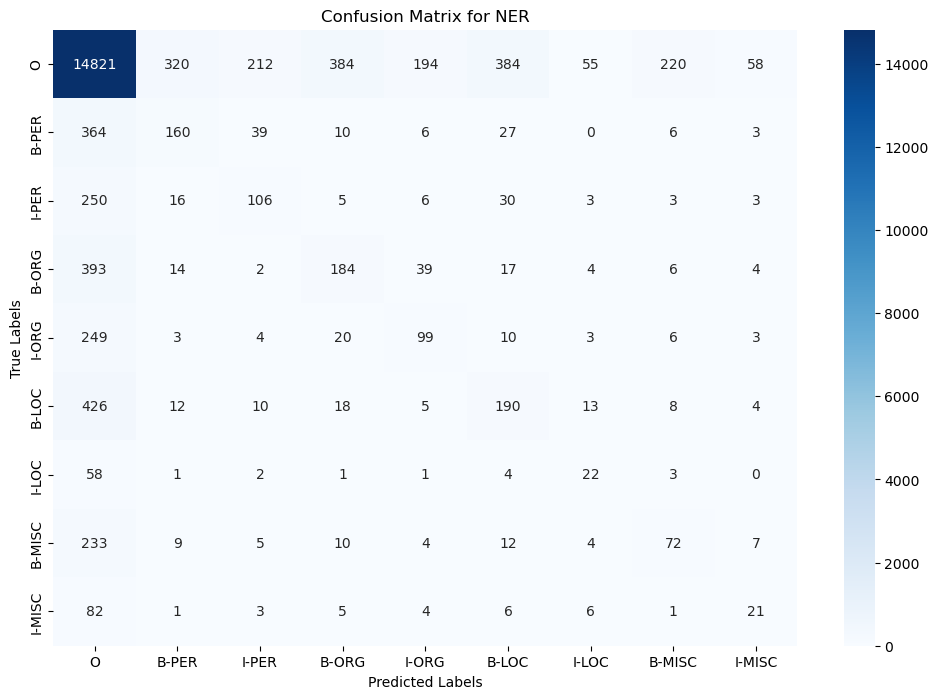

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

min_length = min(len(true_labels_flat), len(predicted_labels_flat))
true_labels_flat = true_labels_flat[:min_length]
predicted_labels_flat = predicted_labels_flat[:min_length]
cm = confusion_matrix(true_labels_flat, predicted_labels_flat, labels=list(id2label.values()))
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(id2label.values()), yticklabels=list(id2label.values()))
plt.title("Confusion Matrix for NER")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()